<a href="https://colab.research.google.com/github/NicolasCuv/World_happiness/blob/main/Copie_de_Copie_de_Rendu_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive


drive.mount('/content/drive')
root_path = "/content/drive/MyDrive/"

def save_df(df, filename):
  df.to_csv(root_path + filename)

def load_df(filename):
  return pd.read_csv(root_path + filename, header=0, index_col=0)

# Chargement des données
df_wh = load_df("df_world_happiness")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**1 - Contexte et pipeline**



###**1 - a) Rappel**


Pour rappel, ce projet consiste à effectuer une analyse approfondie des données collectées par le World Happiness Report. 

L'objectif pour cette seconde partie est donc de créer un modèle pour prédire les données pour l'année 2022.

Pour cela et pour nous rapprocher au mieux des nouvelles valeurs du rapport 2022, nous devons donc découvrir les variables qui influencent notre valeur cible 'Life Ladder', pour obtenir un modèle de prédiction au plus proche de la réalité.




Pour cette partie modélisation, il existe une large variété d’algorithmes de Machine Learning. Ici, puisque nous disposons d'une variable cible 'Life Ladder', nous sommes donc dans un **modèle d'apprentissage supervisé**. 

Pour rappel, l'apprentissage supervisé, à partir de données labellisées (dites aussi étiquetées), cherche à prédire cette variable cible. On a à disposition des variables explicatives et on veut prédire l'information contenue dans la variable cible. Les données disponibles sont labellisées, cela signifie que l'on connaît la valeur de la variable cible pour ces données. Cela est nécessaire pour permettre au modèle de s'entraîner et d'apprendre sur les données. 

L'apprentissage supervisé peut être divisé en deux principales techniques, permettant de comprendre les relations entre les données :
* **La régression** : On cherche à prédire une variable de type quantitatif.
* **La classification** : On cherche à prédire une variable de type qualitatif.

Ici, notre variable cible 'Life Ladder' est le résultat d'un score, que nous pouvons considérer comme une **variable continue**. Par conséquent, nous pourrons utiliser des **algorithmes de régressions**.



###**1 - b) Premiers essais**

Comme expliqué précédemment, nous souhaitons commencer nos premières tentatives sur des modèles de régression simples. 

Après plusieurs entrainements, nous nous sommes rendu compte qu'il était nécessaire de faire évoluer notre jeu de données précédent par l'ajout d'un set de validation (il est courant d'évaluer les performances d'un modèle sur un jeu de données qu'il n'a pas encore vu) mais également en applicant un code en forme de pipeline. 

Cela nous permettra également de faire notre sélection de modèles avec de bonnes performances et d'identifier s'il y a un phénomène de surapprentissage ou non.
Pour rappel, le surapprentissage peut apparaitre sur un jeu de données lorsqu'un modèle est trop complexe pour un jeu de données trop simple.

Le jeu de validation nous permettra également d'obtenir les meilleurs hyperparamètres pour le futur modèle de prédiction.

Voici donc le code du jeu de données actualisé et restructuré :


In [ ]:
X = df_wh.drop('Life_Ladder', axis=1)
y = df_wh['Life_Ladder']

# Division et transformations des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

numerical_columns = X.select_dtypes(include=['int64','float64']).columns
categorical_columns = X.select_dtypes(exclude=['int64','float64']).columns

num_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', RobustScaler())])

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transform, numerical_columns),
                                               ('cat', cat_transformer, categorical_columns)])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_val_scaled = preprocessor.transform(X_val)

Dans nos premiers essais, nous avons également essayé d'appliquer une combinaison de modèles polynomials et de régressions linéaires. L'avantage de cette combinaison est d'inclure les variables non linéaires. 

Nous n'allons pas donner suite à cette combinaison car elle influence peu les scores : uniquement de 0,01 par rapport à un modèle linéaire de régression classique.

In [ ]:
df_wh.describe()

,Life_Ladder,Log_GDP_per_capita,Social_support,Healthy_life_expectancy,Freedom_to_make_life_choices,Generosity,Perceptions_of_corruption,Positive_affect,Negative_affect
count,2098.000000,2062.000000,2085.000000,2043.000000,2066.000000,2009.000000,1988.000000,2089.000000,2087.000000
mean,5.471402,9.373060,0.812709,63.478503,0.746094,-0.001027,0.745650,0.713546,0.270652
std,1.112676,1.154247,0.118203,7.468780,0.140766,0.161400,0.186261,0.104734,0.085379
min,2.375000,6.635000,0.290000,32.300000,0.258000,-0.335000,0.035000,0.322000,0.083000
25%,4.652250,8.470500,0.750000,58.704500,0.652000,-0.115000,0.688750,0.636000,0.207000
50%,5.392000,9.462000,0.835000,65.280000,0.767000,-0.027000,0.801000,0.726000,0.261000
75%,6.282500,10.360750,0.905000,68.660000,0.859000,0.089000,0.869000,0.799000,0.323000
max,8.019000,11.648000,0.987000,77.100000,0.985000,0.698000,0.983000,0.944000,0.705000


In [ ]:
#Modèle PolynomialFeatures
poly_param_grid = {
    'degree': [2, 3, 4],
    'include_bias': [True, False]
}

polynomial_reg = PolynomialFeatures()
poly_grid_search = GridSearchCV(polynomial_reg, poly_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
poly_grid_search.fit(X_train_scaled, y_train)

"""
# Ajouter PolynomialFeatures au pipeline de prétraitement numérique
num_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('poly', PolynomialFeatures(degree=poly_best_model.degree, include_bias=poly_best_model.include_bias)),
                                ('scaler', RobustScaler())])

# Mettre à jour le préprocesseur
preprocessor = ColumnTransformer(transformers=[('num', num_transform, numerical_columns),
                                               ('cat', cat_transformer, categorical_columns)])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_val_scaled = preprocessor.transform(X_val)"""

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


"\n# Ajouter PolynomialFeatures au pipeline de prétraitement numérique\nnum_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),\n                                ('poly', PolynomialFeatures(degree=poly_best_model.degree, include_bias=poly_best_model.include_bias)),\n                                ('scaler', RobustScaler())])\n\n# Mettre à jour le préprocesseur\npreprocessor = ColumnTransformer(transformers=[('num', num_transform, numerical_columns),\n                                               ('cat', cat_transformer, categorical_columns)])\n\nX_train_scaled = preprocessor.fit_transform(X_train)\nX_test_scaled = preprocessor.transform(X_test)\nX_val_scaled = preprocessor.transform(X_val)"

###**1 - c) Suite des essais et hyperparamètres**

Ensuite, nous avons également commencé à tester un modèle RandomForest avec des hyperparamètres simples grâce à cette pipeline. L'objectif était d'obtenir un premier résultat, avec des temps de calcul limités.

Grâce à la méthode "start time" et "end time", nous avons pu mesurer ces étapes qui peuvent parfois allonger les délais de calculs, pour pouvoir sélectionner les hyperparamètres.

In [ ]:
#Recherche du meilleur modèle avec RandomForestRegressor 

#Hyperparamètres - Test rapide (quelques secondes)

#Début chrono
start_time = time.time()
forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [2, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}
"""
##avec des paramètres de délais moins de 10 min
start_time = time.time()
forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}
"""
#Hyperparamètres - Test moyen (environ une dizaine de minutes)
"""
#Début chrono
start_time = time.time()
forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
"""
#Hyperparamètres - Test long (environ 1h42)
"""
#Début chrono
start_time = time.time()
forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
"""
#Début chrono
start_time = time.time()

forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
forest_grid_search.fit(X_train_scaled, y_train)
forest_best_model = forest_grid_search.best_estimator_

end_time = time.time()

# Calcul du temps d'exécution
execution_time = end_time - start_time
print("Temps d'exécution: {:.2f} secondes".format(execution_time))

Temps d'exécution: 8.93 secondes


Ici, nous avons testé différents scénarios (profondeurs de paramètres) avec différentes durées d'exécution: 33 secondes, environ 10 minutes, et environ 1h42.

Plus les paramètres sont profonds et complexes (ainsi que le temps d'éxécution long), plus nous pouvons constater l'apparition du surapprentissage.  
C'est pourquoi nous avons décidé de ne pas continuer d'autres tests pour aller plus loin pour ne pas accentuer ce phénomène.




#**2 - Evaluation des modèles**

###**2 - a) Premiers modèles : LinearRegression et RamdomForestRegression**

Enfin, nous allons maintenant essayer deux modèles de prédiction simples :
* **La régression linéaire** :
C'est un modèle de régression qui cherche à établir une relation linéaire entre une variable, dite expliquée, et une ou plusieurs variables, dites explicatives.

* **La forêt d’arbres de décision** :
Un arbre de décision aide à prendre une décision grâce à une série de questions (aussi appelées tests) dont la réponse (oui/non) mènera à la décision finale. Sur l’arbre, chaque question correspond à un noeud c’est-à-dire à un endroit où une branche se sépare en deux branches. En fonction de la réponse à chaque question, nous allons nous orienter vers telle ou telle branche de l’arbre pour finalement arriver sur une feuille de l’arbre (ou extrémité) qui contiendra la réponse à notre question.

In [ ]:

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

#Modèles Linear et Forest
y_pred_linear_train = linear_reg.predict(X_train_scaled)
y_pred_linear_val = linear_reg.predict(X_val_scaled)

y_pred_forest_train = forest_best_model.predict(X_train_scaled)
y_pred_forest_val = forest_best_model.predict(X_val_scaled)

#Métriques d'évaluation pour les ensembles d'entraînement et de validation
mse_linear_train = mean_squared_error(y_train, y_pred_linear_train)
r2_linear_train = r2_score(y_train, y_pred_linear_train)
mse_linear_val = mean_squared_error(y_val, y_pred_linear_val)
r2_linear_val = r2_score(y_val, y_pred_linear_val)

mse_forest_train = mean_squared_error(y_train, y_pred_forest_train)
r2_forest_train = r2_score(y_train, y_pred_forest_train)
mse_forest_val = mean_squared_error(y_val, y_pred_forest_val)
r2_forest_val = r2_score(y_val, y_pred_forest_val)

#Résultats
print("Linear Regression - Train set: MSE = {:.2f}, R2 = {:.2f}".format(mse_linear_train, r2_linear_train))
print("Linear Regression - Validation set: MSE = {:.2f}, R2 = {:.2f}".format(mse_linear_val, r2_linear_val),"\n")
print("Random Forest - Train set: MSE = {:.2f}, R2 = {:.2f}".format(mse_forest_train, r2_forest_train))
print("Random Forest - Validation set: MSE = {:.2f}, R2 = {:.2f}".format(mse_forest_val, r2_forest_val))


Linear Regression - Train set: MSE = 0.11, R2 = 0.91
Linear Regression - Validation set: MSE = 0.13, R2 = 0.89 

Random Forest - Train set: MSE = 0.15, R2 = 0.88
Random Forest - Validation set: MSE = 0.23, R2 = 0.81



On obtient les résultats suivants :

* Linear Regression - Train set: MSE = 0.11, R2 = 0.91

* Linear Regression - Validation set: MSE = 0.13, R2 = 0.89 

* Random Forest - Train set: MSE = 0.15, R2 = 0.88

* Random Forest - Validation set: MSE = 0.24, R2 = 0.81

Ici, le modèle Linear Regression dispose des meilleurs résultats, même si ceux du Random Forest sont satisfaisants : il y a peu d'écart entre les résultats du jeu de validation et d'entrainement et un taux de prédiction élevé (R2 score à 0,91). Il n'y a également pas de phénomène de surapprentissage.



###**2 - b) Seconds modèles : LassoRegression et RidgeRegression**

Plusieurs modèles de régression avec régularisation sont également disponibles : ElasticNet, SVR, Ridge et Lasso. 

Nous allons nous concentrer ici uniquement sur les modèles Ridge et Lasso.

* **La régression Lasso** (Least Absolute Shrinkage and Selection Operator regression) : C'est un type de méthode de régression linéaire, qui a pour objectif de minimiser la somme des erreurs quadratiques entre les valeurs prédites et réelles de la variable dépendante, sous réserve d'une contrainte sur la somme des valeurs absolues des coefficients de régression.

* **La régression Ridge** : La principale différence entre la régression Lasso et la régression de Ridge est que Lasso peut en fait définir certains coefficients sur exactement zéro, éliminant ainsi ces caractéristiques du modèle, tandis que la régression Ridge ne peut que réduire les coefficients vers zéro mais pas les définir exactement sur zéro.

In [ ]:
from sklearn.linear_model import Lasso, Ridge

#Modèle Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso_train = lasso_reg.predict(X_train_scaled)
y_pred_lasso_val = lasso_reg.predict(X_val_scaled)
mse_lasso_train = mean_squared_error(y_train, y_pred_lasso_train)
r2_lasso_train = r2_score(y_train, y_pred_lasso_train)
mse_lasso_val = mean_squared_error(y_val, y_pred_lasso_val)
r2_lasso_val = r2_score(y_val, y_pred_lasso_val)

#Modèle Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge_train = ridge_reg.predict(X_train_scaled)
y_pred_ridge_val = ridge_reg.predict(X_val_scaled)
mse_ridge_train = mean_squared_error(y_train, y_pred_ridge_train)
r2_ridge_train = r2_score(y_train, y_pred_ridge_train)
mse_ridge_val = mean_squared_error(y_val, y_pred_ridge_val)
r2_ridge_val = r2_score(y_val, y_pred_ridge_val)

#Résultats
print("Lasso Regression - Train set: MSE = {:.2f}, R2 = {:.2f}".format(mse_lasso_train, r2_lasso_train))
print("Lasso Regression - Validation set: MSE = {:.2f}, R2 = {:.2f}".format(mse_lasso_val, r2_lasso_val),"\n")
print("Ridge Regression - Train set: MSE = {:.2f}, R2 = {:.2f}".format(mse_ridge_train, r2_ridge_train))
print("Ridge Regression - Validation set: MSE = {:.2f}, R2 = {:.2f}".format(mse_ridge_val, r2_ridge_val))


Lasso Regression - Train set: MSE = 0.35, R2 = 0.73
Lasso Regression - Validation set: MSE = 0.37, R2 = 0.70 

Ridge Regression - Train set: MSE = 0.12, R2 = 0.91
Ridge Regression - Validation set: MSE = 0.14, R2 = 0.89



On obtient les résultats suivants :

* Lasso Regression - Train set: MSE = 0.35, R2 = 0.73

* Lasso Regression - Validation set: MSE = 0.37, R2 = 0.70 

* Ridge Regression - Train set: MSE = 0.12, R2 = 0.91

* Ridge Regression - Validation set: MSE = 0.14, R2 = 0.89

Ici, le modèle **Ridge Regression donne exactement les mêmes résultats que ceux du modèle Linear Regression**. Ils sont à privilégier face au score du modèle Lasso Regression qui dispose d'un taux de R2 plus bas.

Suite à nos différentes itérations précédentes, nous voulions également préciser que l'ensemble du code ci-dessous peut être simplifier avec le code suivant :


In [ ]:
#Modèles à évaluer
models = {'Linear Regression': linear_reg,
          'Random Forest': forest_best_model,
          'Lasso': lasso_reg,
          'Ridge': ridge_reg}

#Boucle sur les modèles et évaluation sur l'ensemble de test
for model_name, model in models.items():
    y_pred_val = model.predict(X_val_scaled)
    mse_test = mean_squared_error(y_val, y_pred_val)
    r2_test = r2_score(y_val, y_pred_val)
    print(f"{model_name} - Test set evaluation: MSE = {mse_test}, R2 = {r2_test}")


Linear Regression - Test set evaluation: MSE = 0.13283690293655998, R2 = 0.891018344137464
Random Forest - Test set evaluation: MSE = 0.22827125887691485, R2 = 0.8127223743682679
Lasso - Test set evaluation: MSE = 0.3687883318041117, R2 = 0.697439776339946
Ridge - Test set evaluation: MSE = 0.13935839361074978, R2 = 0.8856680022019499


###**2 - c) Visualisations graphiques**

Enfin, avant de prendre notre décision final, nous devons également observer la distribution des erreurs résidueles du modèle selon une loi normale, à l'aide d'un graphique. En effet, un bon score R2 est insuffisant.

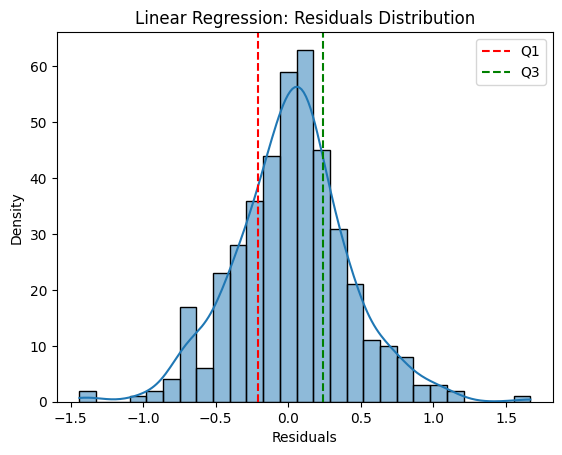

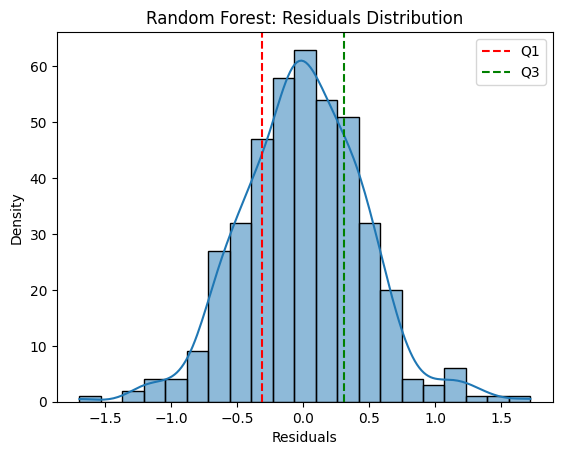

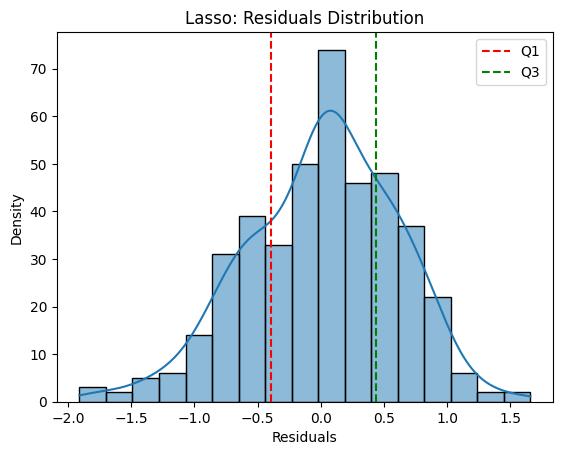

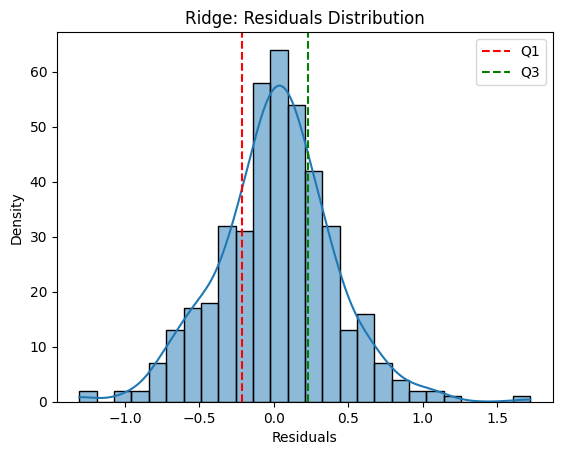

In [ ]:
import seaborn as sns
def plot_residuals(model_name, model, X_test_scaled, y_test):
    y_pred_test = model.predict(X_test_scaled)
    residuals = y_test - y_pred_test
    std_residuals = np.std(residuals)
    q1 = np.percentile(residuals, 25)
    q3 = np.percentile(residuals, 75)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=q1, color='r', linestyle='--', label='Q1')
    plt.axvline(x=q3, color='g', linestyle='--', label='Q3')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title(f'{model_name}: Residuals Distribution')
    plt.legend()
    plt.show()

# Boucle sur les modèles et affichage des erreurs résiduelles
for model_name, model in models.items():
    plot_residuals(model_name, model, X_test_scaled, y_test)


Nous observons que pour la regression linéaire et le ridge regression, la distribution des erreures résidueles suit une loi normale, ce qui signifie que la majorité  des erreures sont petites et que les erreurs importantes sont peu fréquentes.
D'autre part, nous pouvons observer que la distribution des erreurs est centrés autour du 0. La moyenne des erreurs est donc proche de 0, écartant la possibilité qu'il y ait un bias systématique dans l'usage de ces 2 modèles.

Linear Regression:


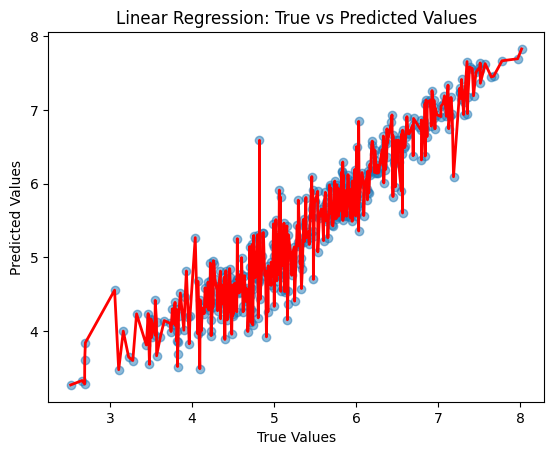

Random Forest:


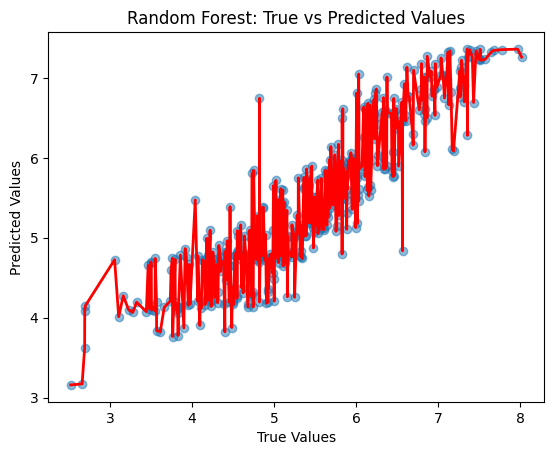

Lasso:


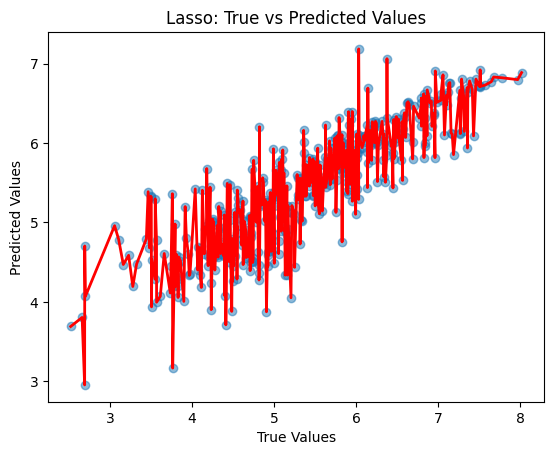

Ridge:


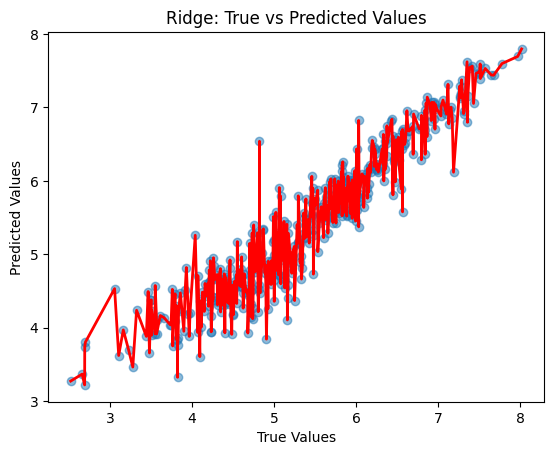

In [ ]:
def plot_predictions(model_name, model, X, y):
    y_pred = model.predict(X)
    
    # Trier les valeurs réelles et prédites pour tracer la courbe rouge
    sorted_indices = y.argsort()
    sorted_y = y.iloc[sorted_indices].values
    sorted_y_pred = y_pred[sorted_indices]
    
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot(sorted_y, sorted_y_pred, color='red', linewidth=2)  # Courbe rouge
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name}: True vs Predicted Values')
    plt.show()

# Boucle sur les modèles et affichage des nuages de points avec la courbe rouge
for model_name, model in models.items():
    print(f"{model_name}:")
    plot_predictions(model_name, model, X_val_scaled, y_val)



Linear Regression:


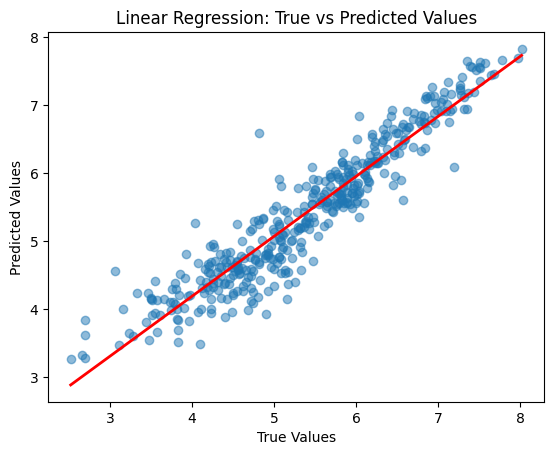

Random Forest:


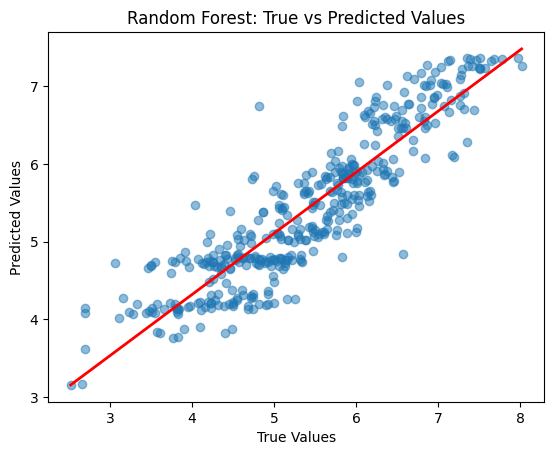

Lasso:


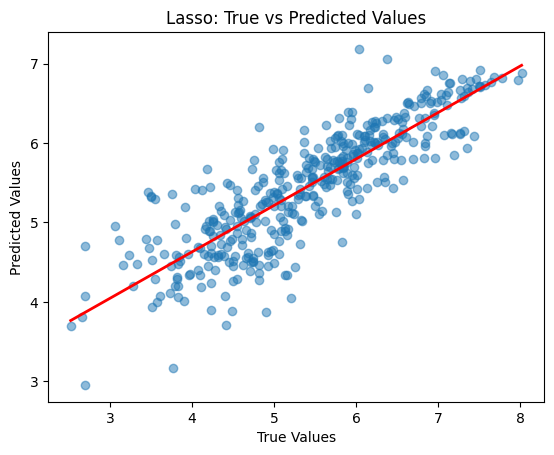

Ridge:


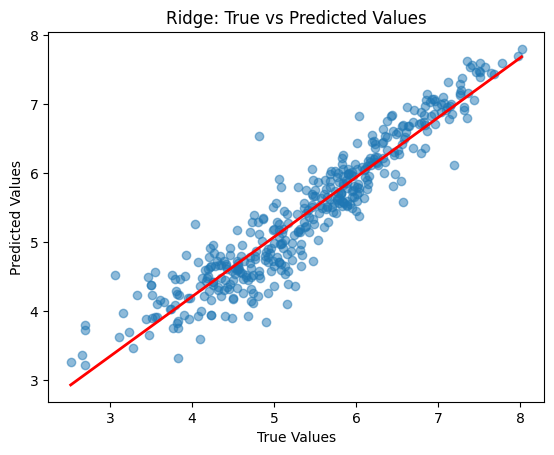

In [ ]:
import numpy as np

def plot_predictions(model_name, model, X, y):
    y_pred = model.predict(X)
    
    plt.scatter(y, y_pred, alpha=0.5)
    
    # Fit a linear regression model to the true values and predictions
    reg_line = np.polyfit(y, y_pred, 1)
    reg_func = np.poly1d(reg_line)
    
    # Create an array of x values for the regression line
    x_reg = np.linspace(y.min(), y.max(), 100)
    
    # Calculate the corresponding y values for the regression line
    y_reg = reg_func(x_reg)
    
    plt.plot(x_reg, y_reg, color='red', linewidth=2)  # Courbe de régression rouge
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name}: True vs Predicted Values')
    plt.show()

# Boucle sur les modèles et affichage des nuages de points avec la courbe de régression
for model_name, model in models.items():
    print(f"{model_name}:")
    plot_predictions(model_name, model, X_val_scaled, y_val)

###**2 - d) Récapitulatif**

Pour rappel, voici les résultats obtenus pour l'ensemble des modèles :



In [ ]:
df_recap = pd.DataFrame({'Modeles' : ['Linear', 'Random', 'Lasso', 'Ridge'],'Train': [0.91, 0.88, 0.73, 0.91], 'Validation': [0.89, 0.81, 0.70, 0.89]})
df_recap.set_index('Modeles')
df_recap.head()


,Modeles,Train,Validation
0,Linear,0.91,0.89
1,Random,0.88,0.81
2,Lasso,0.73,0.70
3,Ridge,0.91,0.89


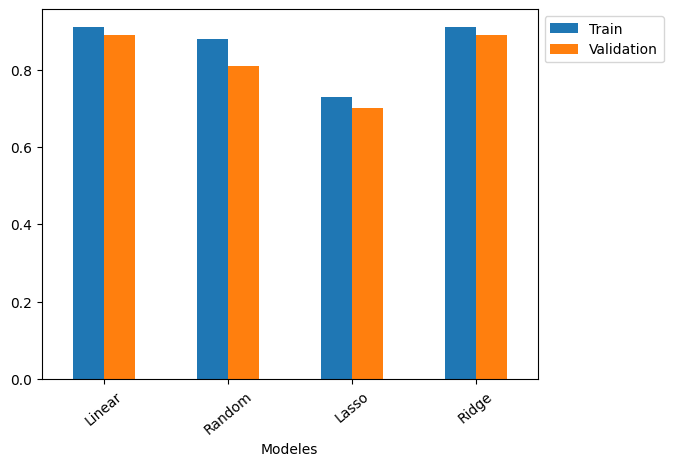

In [ ]:
df_recap.plot.bar(x = 'Modeles', y=['Train', 'Validation'])
plt.xticks(rotation= 40)
plt.legend(bbox_to_anchor = (1,1));

Ce graphique nous permet de clairement visualiser le résultat de l'ensemble des modèles. Ici, deux modèles affichent les scores les plus élévés: Linear et Ridge.

Nous allons finalement privilégier le modèle : **le Linear Regression**.


#**3 - Sélection et application du modèle**

Au vu des précédentes informations, nous avons donc finalement choisi le modèle Linear Regression. 

La prochaine étape consiste donc à l'appliquer au jeu de données test.


In [ ]:
#Modèle LinearRegression
best_model = linear_reg  

# Évaluer le modèle final sur l'ensemble de test
y_pred_test = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Test set evaluation: MSE = {}, R2 = {}".format(mse_test, r2_test))


Pour rappel, nous disposions d'un score R2 de 0.89 sur le jeu de validation Linear Regression. Cela est donc très proche du score ci-dessus: 0.87.

Cela nous laisse penser que ce modèle pourrait permettre d'obtenir des prédictions précises du "Life ladder" pour l'année 2022.

# Interprétabilité des résultats du modèle


In [ ]:
# Obtenez les noms des colonnes après la transformation one-hot encoding
onehot_columns = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns))

# Combinez les colonnes numériques et les colonnes one-hot
all_columns = numerical_columns.to_list() + onehot_columns

# Créez un DataFrame pour afficher les coefficients
coef_df = pd.DataFrame({'Feature': all_columns, 'Coefficient': best_model.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Affichez le DataFrame
print(coef_df)


In [ ]:
import matplotlib.pyplot as plt

# Sélectionnez les 10 variables les plus importantes
top_n = 10
top_coefs_df = coef_df.nlargest(top_n, 'Coefficient')

# Créez un graphique à barres horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_coefs_df['Feature'], top_coefs_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Most Important Features')
plt.gca().invert_yaxis()  # Inversez l'axe y pour afficher la caractéristique la plus importante en haut
plt.show()


#**4 - Conclusion générale**

##**4 - a) Problématique**

##**4 - b) Axes de réflexion**

Lors de ce projet, nous n'avons pas rencontré de difficultés majeures. Cependant, nous sommes conscients que des axes d'amélioration sont possibles.

Nous aurions par exemple aimé comparer nos résultats finaux avec le nouveau rapport du World Happiness Report 2023, sortie sur la fin de la période du projet (20 mars 2023). Cela nous aurait permis d'affiner nos modèles de prédictions et de les comparer avec les nouvelles variables de l'année 2022.

Nous aurions également pu appliquer d'autres modèles de régression avec régularisation comme les modèles ElasticNet ou bien SVR.